<h1>Appendix D: AutoEncoder with Tensorflow

In [1]:
#pip install pandas==2.0.3
#pip install numpy==1.21 --user
#pip install
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib
import matplotlib.pyplot as plt 
# Ignore harmless warnings 
import warnings 
warnings.filterwarnings("ignore") 
# Read the CSV data into a Pandas DataFrame
df = pd.read_csv('D:\\Download\\Tool_Sensor_Data.csv')
print(df.shape)
df.head()

(14844, 90)


,TimeStamp,ToolName,TOOL_ID,Run,RunStartTime,DATA_QUALITY,EQPType,HasComments,LOT_ID,LogicalRecipeID,...,yqScxEFPLde,jrsnDLYHnMHD,CalcStepSeq,CalcLoopSeq,RunTag,Unnamed: 85,Unnamed: 86,Unnamed: 87,Unnamed: 88,Unnamed: 89
0,21/3/2023 19:14,A,A,62301,12:14:19 AM,63.49,A,0,A,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,21/3/2023 19:14,A,A,62301,12:14:19 AM,63.49,A,0,A,A,...,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2,21/3/2023 19:14,A,A,62301,12:14:19 AM,63.49,A,0,A,A,...,NaN,NaN,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN
3,21/3/2023 19:14,A,A,62301,12:14:19 AM,63.49,A,0,A,A,...,NaN,NaN,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN
4,21/3/2023 19:14,A,A,62301,12:14:19 AM,63.49,A,0,A,A,...,NaN,NaN,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN


In [2]:
# Will not use TimeStamp and consider 1,2,3 series of data
if 'TimeStamp' in df.columns:
    df = df.drop('TimeStamp', axis=1)
df = df.drop('RunStartTime', axis=1)

# Unsure if ToolName, RecipeID is useful or not, just convert the character into integer
# Define the function to convert character to number
def char_to_num(char):
    return ord(char) - 64

single_char_columns = [col for col in df.columns if all(len(str(val)) == 1 for val in df[col])]
#print(single_char_columns)

for column in single_char_columns:
    #print(df[column].dtypes)
    if df[column].dtypes == 'object':
        df[column] = df[column].apply(char_to_num)
        
# Find/Validate if any more non-integer columns
for column in df.columns:
    if df[column].dtypes == 'object':
        #print(column, df[column].dtypes)
        print("  ", df[column].iloc[0])
        
# Verify if those columns are not useful, drop it
for column in df.columns:
    if df[column].dtypes == 'object':
        #print(column, df[column].dtypes, 'DROP')
        #print("  ", df[column].iloc[0], 'DROP')
        df = df.drop(column, axis=1)
        
non_empty_columns_per_row = df.count(axis=1)
non_empty_columns_per_row

# Visualize the Rows with Numbers vs Rows without Numbers/Empty
# Generate x-coordinates as a sequence of numbers
x_data = list(range(1, len(non_empty_columns_per_row) + 1))

print(len(df.columns))
threshold = len(df.columns)/2
print(threshold)

# Remove empty rows below threshold
print('Before remove=',df.shape)
df = df.dropna(thresh=threshold)
print('After remove=',df.shape)

print(df.shape)
df = df.drop_duplicates()
print(df.shape)

# Remove Useless Columns
# Fill in empty cell?
df = df.fillna(0)
column_stddev = {}
for column in df.columns:
    std_deviation = df[column].std()
    #print(column, std_deviation)
    if std_deviation == 0:
        #print(column, std_deviation, "DROP")
        df = df.drop(column, axis=1)
        #df.drop(column, inplace=True, axis=1)
    else:
        column_stddev[column]=std_deviation
        
print(df.shape)
df_bak=df

   Process Lot
   Production
   StartOfRun
   WaferStart
   WaferStart
83
41.5
Before remove= (14844, 83)
After remove= (14388, 83)
(14388, 83)
(13652, 83)
(13652, 51)


In [3]:
# Get unique run numbers 
runs = df['Run'].unique()
print('Total Unique Runs=',len(runs))
#runs

df_run = pd.DataFrame()
i=0
# Calculate each Run's lenght and record inside df_run
for run in runs:
    count = (df['Run'] == run).sum()
    df_run.loc[i, 'Run'] = run
    df_run.loc[i, 'Count'] = count
    i=i+1
    #print(run,count)
df_run.head()

Total Unique Runs= 228


,Run,Count
0,62301.0,57.0
1,62302.0,63.0
2,62303.0,56.0
3,62304.0,51.0
4,62305.0,60.0


In [4]:
# remove all columns except one
check_column = 'SwpYipezsdueC'
for column in df.columns:
    #if column != 'ETcatZBXS' and column != 'Run':
    if column != check_column and column != 'Run':
        #print(column,"DROP")
        df=df.drop(column, axis=1)
print(df.shape)
print(df.head())
# Split data into dicts by run number
data_by_run = {run: df[df['Run'] == run] for run in runs}

(13652, 2)
     Run  SwpYipezsdueC
1  62301          125.0
2  62301          123.0
3  62301          123.0
4  62301          123.0
5  62301          123.0


In [5]:
# Get the max lenght for resampling
new_df = pd.DataFrame()
i=0
mydict={}
for run, df1 in data_by_run.items():
    #print(f"Run {run}")
    i = i + 1
    mylist = df1[check_column].tolist()
    mydict[run]=len(mylist)

#for key, value in mydict.items():
    #print(key, ":", value)
max_key = max(mydict, key=lambda key: mydict[key])
max_value = mydict[max_key]
print('Maximum Run record lenght =', max_value)

Maximum Run record lenght = 87


In [6]:
# CONVERT the time series row to column, RESAMPLE and put into new dataframe
new_df = pd.DataFrame()
i=0
for run, df1 in data_by_run.items():
    #print(f"Run {run}")
    i = i + 1
    mylist = df1[check_column].tolist()
    #mylist = df1['ETcatZBXS'].tolist()
    # Resample mylist using linear interpolation to match the length of the longer list
    if len(mylist) < max_value:
        x1 = np.arange(len(mylist))
        x2 = np.linspace(0, len(mylist) - 1, max_value)
        mylist = np.interp(x2, x1, mylist)
    mylist = np.insert(mylist, 0, run)
    new_row = pd.DataFrame([mylist])
    #new_df = new_df.append(new_row, ignore_index=True)
    new_df = pd.concat([new_df, new_row], ignore_index=True)
new_df.set_index(0, inplace=True)
new_df

,1,2,3,4,5,6,7,8,9,10,...,78,79,80,81,82,83,84,85,86,87
0,,,,,,,,,,,,,,,,,,,,,
62301.0,125.0,123.697674,123.00000,123.000000,123.000000,123.000000,123.000000,123.558140,124.000000,124.000000,...,139.000000,139.000000,139.000000,138.906977,138.255814,138.000000,137.953488,137.302326,137.000000,137.0
62302.0,120.0,120.000000,120.00000,120.000000,120.000000,119.395349,119.000000,119.046512,119.767442,120.000000,...,139.000000,138.767442,138.046512,138.000000,138.000000,138.000000,138.000000,138.000000,137.441860,136.0
62303.0,121.0,121.000000,121.00000,121.000000,121.000000,121.197674,121.837209,122.000000,122.116279,122.755814,...,139.000000,139.000000,139.000000,139.000000,139.000000,139.000000,138.837209,137.558140,137.000000,137.0
62304.0,123.0,123.000000,123.00000,123.000000,123.000000,123.000000,123.488372,124.000000,124.000000,124.000000,...,138.232558,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.0
62305.0,120.0,120.000000,120.00000,119.941860,119.255814,119.000000,119.116279,119.802326,120.000000,120.000000,...,139.825581,140.000000,139.802326,139.116279,139.000000,138.744186,138.058140,138.000000,138.000000,138.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62596.0,124.0,124.000000,124.00000,124.000000,124.232558,124.790698,125.000000,125.000000,125.465116,126.000000,...,139.000000,138.465116,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.0
62597.0,120.0,120.000000,120.00000,119.906977,119.209302,119.000000,119.186047,119.883721,120.000000,120.000000,...,140.000000,140.000000,139.883721,139.186047,139.000000,138.790698,138.093023,138.000000,138.000000,138.0
62598.0,123.0,123.000000,123.00000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.546512,...,139.000000,138.930233,138.313953,138.000000,138.000000,137.465116,137.000000,137.000000,136.616279,136.0


In [7]:
# Drop last column to make it 86, even number - does not work, hence add one more column
#new_df=new_df.drop(87, axis=1)
#error:last_column = df[['87']]
last_column = new_df.iloc[:, -1]
# Concatenate the last column to the DataFrame
new_df = pd.concat([new_df, last_column], axis=1)
print(new_df.shape)
new_df

(228, 88)


,1,2,3,4,5,6,7,8,9,10,...,79,80,81,82,83,84,85,86,87,87
0,,,,,,,,,,,,,,,,,,,,,
62301.0,125.0,123.697674,123.00000,123.000000,123.000000,123.000000,123.000000,123.558140,124.000000,124.000000,...,139.000000,139.000000,138.906977,138.255814,138.000000,137.953488,137.302326,137.000000,137.0,137.0
62302.0,120.0,120.000000,120.00000,120.000000,120.000000,119.395349,119.000000,119.046512,119.767442,120.000000,...,138.767442,138.046512,138.000000,138.000000,138.000000,138.000000,138.000000,137.441860,136.0,136.0
62303.0,121.0,121.000000,121.00000,121.000000,121.000000,121.197674,121.837209,122.000000,122.116279,122.755814,...,139.000000,139.000000,139.000000,139.000000,139.000000,138.837209,137.558140,137.000000,137.0,137.0
62304.0,123.0,123.000000,123.00000,123.000000,123.000000,123.000000,123.488372,124.000000,124.000000,124.000000,...,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.0,138.0
62305.0,120.0,120.000000,120.00000,119.941860,119.255814,119.000000,119.116279,119.802326,120.000000,120.000000,...,140.000000,139.802326,139.116279,139.000000,138.744186,138.058140,138.000000,138.000000,138.0,138.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62596.0,124.0,124.000000,124.00000,124.000000,124.232558,124.790698,125.000000,125.000000,125.465116,126.000000,...,138.465116,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.0,138.0
62597.0,120.0,120.000000,120.00000,119.906977,119.209302,119.000000,119.186047,119.883721,120.000000,120.000000,...,140.000000,139.883721,139.186047,139.000000,138.790698,138.093023,138.000000,138.000000,138.0,138.0
62598.0,123.0,123.000000,123.00000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.546512,...,138.930233,138.313953,138.000000,138.000000,137.465116,137.000000,137.000000,136.616279,136.0,136.0


In [147]:
# After resampling, convert back to long series of data for autoencoder
#df_melted = df.melt(id_vars=[new_df.columns[0]], var_name="Series Order", value_name="Data Point")
#df_melted = df.melt(id_vars=[new_df.index], var_name="Series Order", value_name="Data Point")
#df_melted
index_variable = new_df.index
index_variable = index_variable.astype(int)

time_df = pd.DataFrame()
i=0
#for run, df1 in new_df.items():
for run, row in new_df.iterrows():
    run = int(run)
    #run = run.astype(int)
    #print(type(row))
    for j, col in enumerate(row[0:], start=1):
        #print(col)
        new_row = pd.DataFrame([[run, col]])
        time_df = pd.concat([time_df, new_row], ignore_index=True)
        #print(new_row)
    #for col in len(new_df)
    #    new_row = [run, col]
    #    time_df = pd.concat([new_df, new_row], ignore_index=True)
    
#X_df = new_df.reset_index(drop=True)
#X = X_df.values
#y = np.arange(1, len(X) + 1)#
time_df.columns = ['Runs', 'Sensor']
time_df

,Runs,Sensor
0,62301,125.000000
1,62301,123.697674
2,62301,123.000000
3,62301,123.000000
4,62301,123.000000
...,...,...
20059,62600,138.162791
20060,62600,138.000000
20061,62600,137.720930
20062,62600,137.000000


<Axes: >

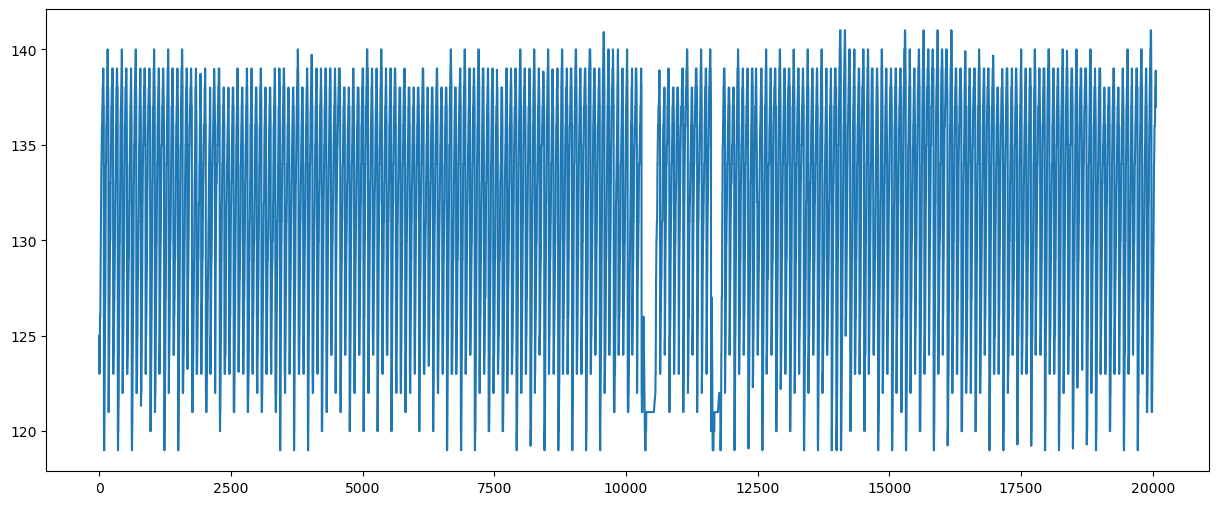

In [148]:
plt.figure(figsize=(15, 6))
#for index, row in new_df.iterrows():
#    plt.plot(row, label=f'Line {index}')  # Plot each row with a label
#plt.show()
time_df['Sensor'].plot()

In [149]:
df=new_df.copy()
df=time_df.copy()
df=df.drop('Runs', axis=1)
#df=df.drop(column, axis=1)
df

,Sensor
0,125.000000
1,123.697674
2,123.000000
3,123.000000
4,123.000000
...,...
20059,138.162791
20060,138.000000
20061,137.720930
20062,137.000000


In [150]:
no_index = df.copy()
no_index = no_index.reset_index(drop=True)
no_index

,Sensor
0,125.000000
1,123.697674
2,123.000000
3,123.000000
4,123.000000
...,...
20059,138.162791
20060,138.000000
20061,137.720930
20062,137.000000


In [151]:
#!pip install tensorflow

<h1>Start TensorFlow

In [152]:
#!pip install tensorflow==2.6.0
#pip install keras==2.6.0 --user
#ok with numpy=1.22
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [153]:
# Normalize and save the mean and std we get,
# for normalizing test data.
training_mean = df.mean()
training_std = df.std()
df_training_value = (df - training_mean) / training_std
print("Number of training samples:", len(df_training_value))

"""
### Create sequences
Create sequences combining `TIME_STEPS` contiguous data values from the
training data.
"""

TIME_STEPS = 88

Number of training samples: 20064


In [154]:
# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)

x_train = create_sequences(df_training_value.values)
print("Training input shape: ", x_train.shape)

Training input shape:  (19977, 88, 1)


In [155]:
# Verify x_train
#x_train[0]
for i in range(19523):
    if(i==19522):
        print(i, "=", len(x_train[i]))
#print(x_train[0])
#print(x_train[228])\

19522 = 88


In [156]:
from tensorflow import keras
from tensorflow.keras import layers
model = keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 44, 32)            256       
_________________________________________________________________
dropout_4 (Dropout)          (None, 44, 32)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 22, 16)            3600      
_________________________________________________________________
conv1d_transpose_6 (Conv1DTr (None, 44, 16)            1808      
_________________________________________________________________
dropout_5 (Dropout)          (None, 44, 16)            0         
_________________________________________________________________
conv1d_transpose_7 (Conv1DTr (None, 88, 32)            3616      
_________________________________________________________________
conv1d_transpose_8 (Conv1DTr (None, 88, 1)            

In [157]:
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
141/141 [==============================] - 18s 79ms/step - loss: 0.1713 - val_loss: 0.0340
Epoch 2/50
141/141 [==============================] - 9s 65ms/step - loss: 0.0357 - val_loss: 0.0188
Epoch 3/50
141/141 [==============================] - 6s 44ms/step - loss: 0.0221 - val_loss: 0.0229
Epoch 4/50
141/141 [==============================] - 6s 43ms/step - loss: 0.0157 - val_loss: 0.0294
Epoch 5/50
141/141 [==============================] - 6s 44ms/step - loss: 0.0124 - val_loss: 0.0258
Epoch 6/50
141/141 [==============================] - 6s 43ms/step - loss: 0.0106 - val_loss: 0.0283
Epoch 7/50
141/141 [==============================] - 6s 42ms/step - loss: 0.0094 - val_loss: 0.0235


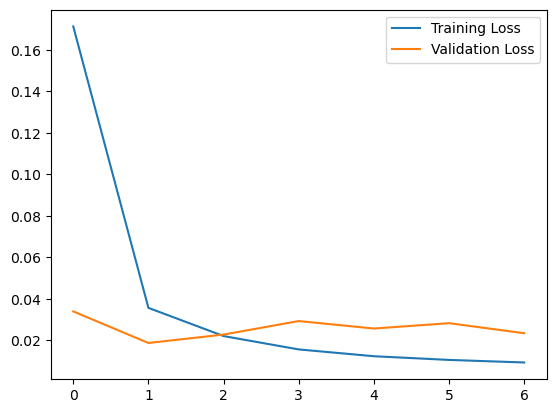

In [158]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

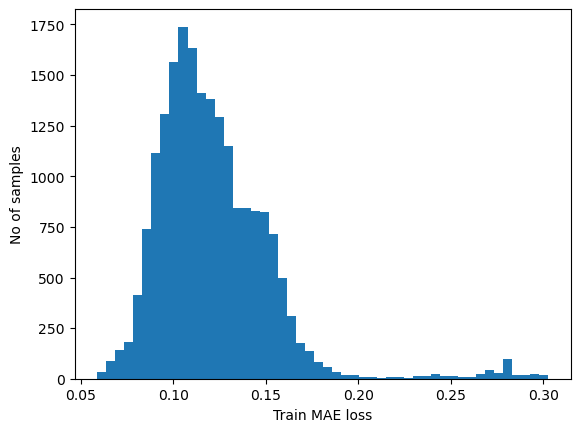

Reconstruction error threshold:  0.30266626008188124


In [188]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

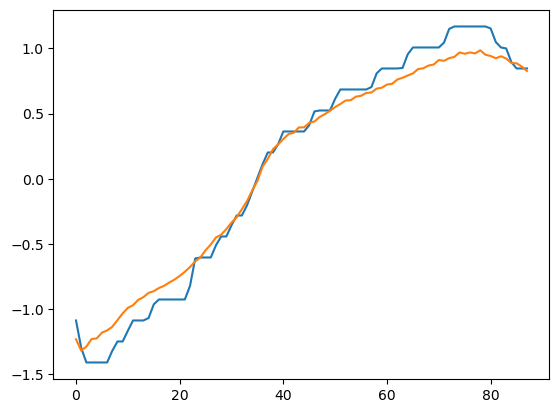

In [189]:
# Checking how the first sequence is learnt
plt.plot(x_train[0])
plt.plot(x_train_pred[0])
plt.show()

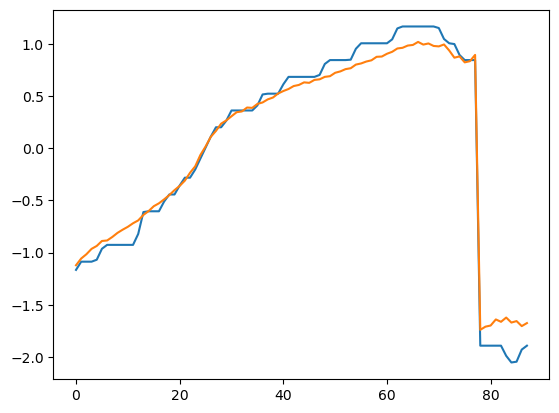

In [190]:
# Checking how the first sequence is learnt
plt.plot(x_train[10])
plt.plot(x_train_pred[10])
plt.show()

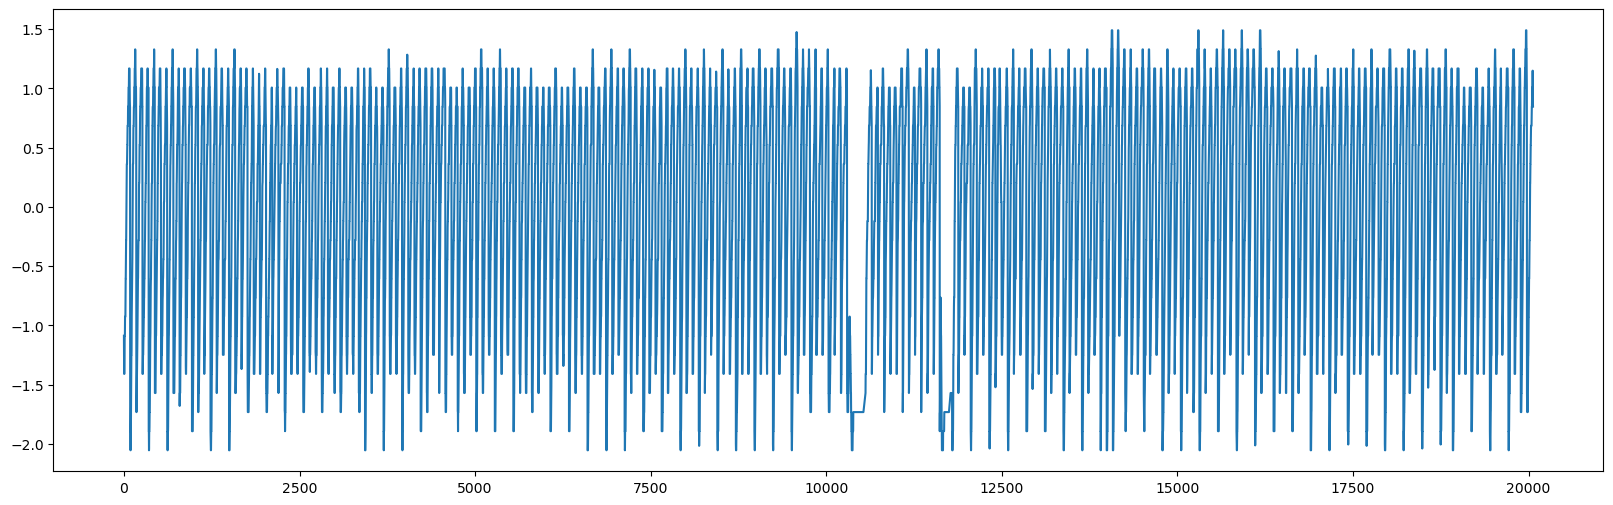

Test input shape:  (19977, 88, 1)


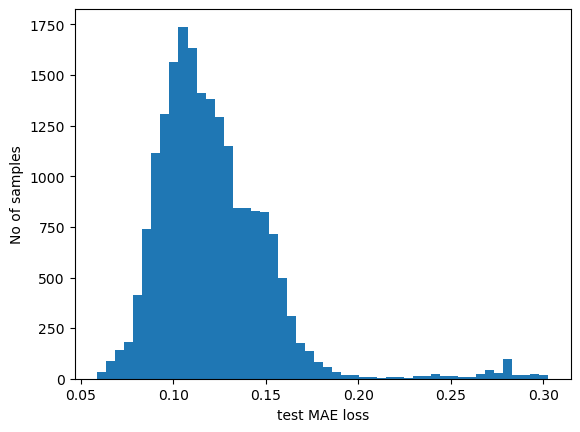

In [191]:
#df_test_value = (df_daily_jumpsup - training_mean) / training_std
df_test_value = (df - training_mean) / training_std
fig, ax = plt.subplots(figsize=(20, 6))
df_test_value.plot(legend=False, ax=ax)
plt.show()

# Create sequences from test values.
x_test = create_sequences(df_test_value.values)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

In [205]:
# Detect all the samples which are anomalies.
print("Reconstruction error threshold: ", threshold)
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
#print("Indices of anomaly samples: ", np.where(anomalies))

Reconstruction error threshold:  0.30266626008188124
Number of anomaly samples:  0


In [230]:
# THRESHOLD - Drop the threshold based on the MAE Loss chart above
new_threshold = 0.15
anomalies = test_mae_loss > new_threshold
print("Number of anomaly samples: ", np.sum(anomalies))
#print("Indices of anomaly samples: ", np.where(anomalies))

Number of anomaly samples:  2705


In [231]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

<Figure size 640x480 with 0 Axes>

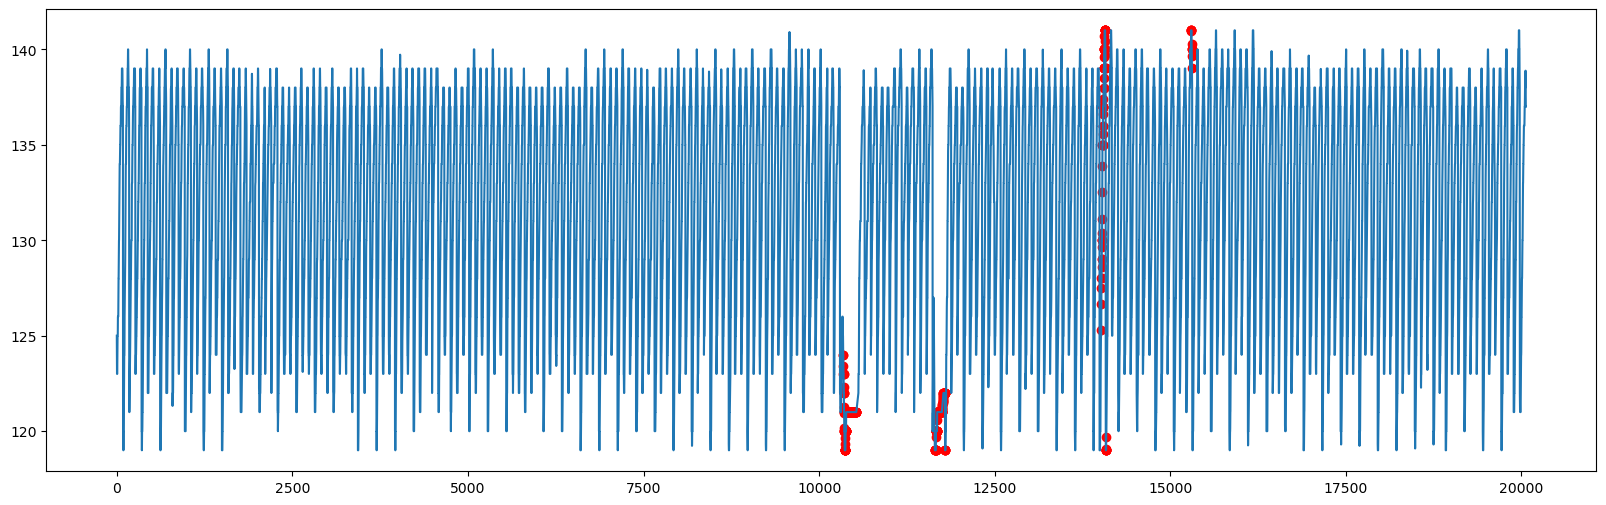

In [232]:
plt.clf()
df_subset = df.iloc[anomalous_data_indices]
fig, ax = plt.subplots(figsize=(20, 6))
df.plot(legend=False, ax=ax)
#df_subset.plot(legend=False, ax=ax, color="r")
ax.scatter(df_subset.index, df_subset['Sensor'], c='red', label='Anomalous Data', marker='o')
plt.show()

In [234]:
#print(type(anomalous_data_indices))

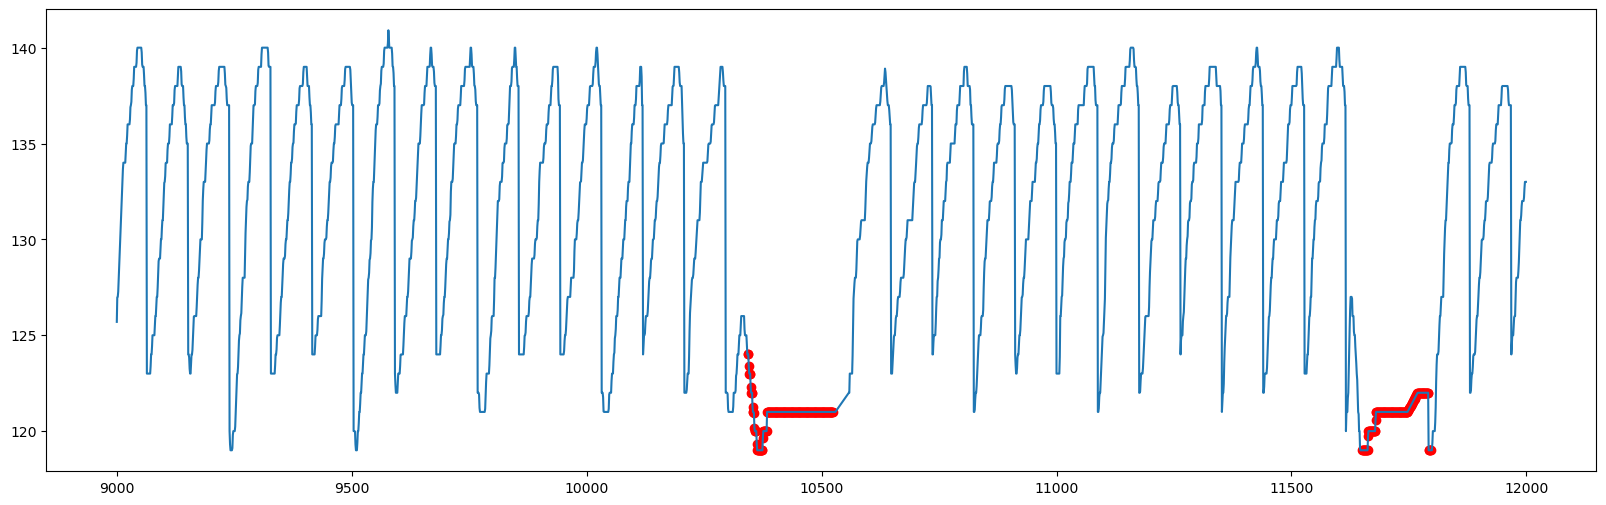

In [235]:
# Zoom into the data
start_range = 9000
end_range = 12000
zoom_df=df.iloc[start_range:end_range]
zoom_anomalous_data_indices = [idx for idx in anomalous_data_indices if start_range <= idx <= end_range]
zoom_df_subset = df.iloc[zoom_anomalous_data_indices]
fig, ax = plt.subplots(figsize=(20, 6))
zoom_df.plot(legend=False, ax=ax)
ax.scatter(zoom_df_subset.index, zoom_df_subset['Sensor'], c='red', label='Anomalous Data', marker='o')
plt.show()

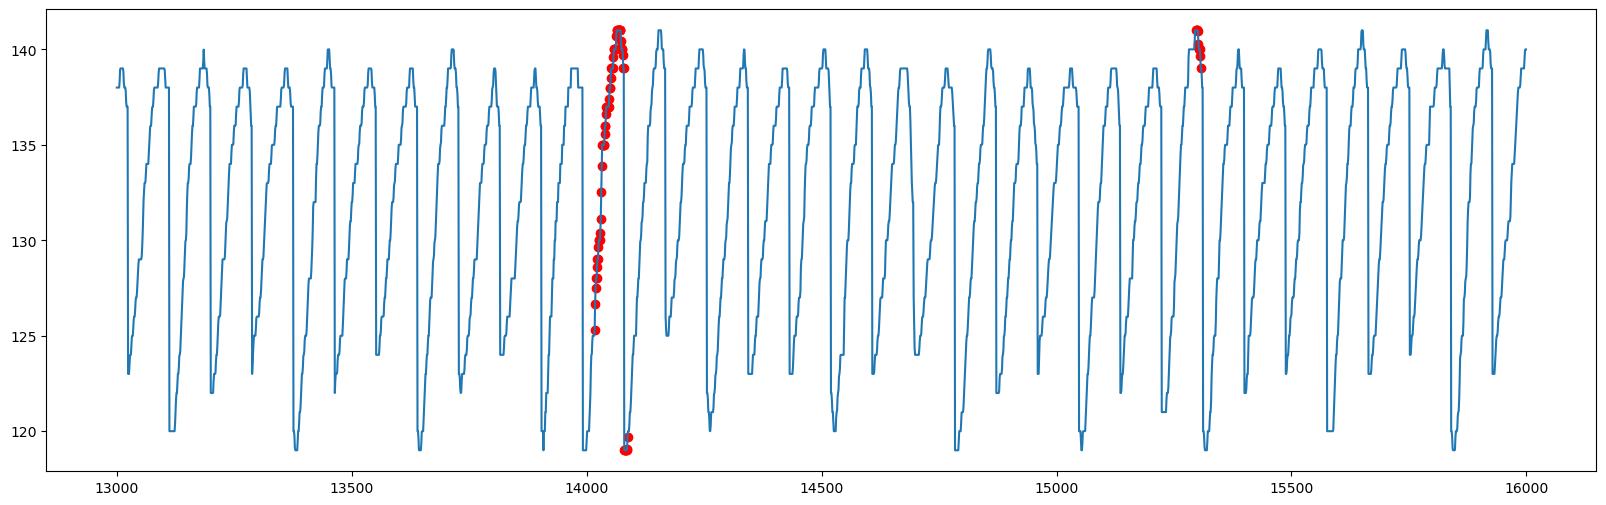

In [236]:
# Zoom into the data
start_range = 13000
end_range = 16000
zoom_df=df.iloc[start_range:end_range]
#zoom_df
zoom_anomalous_data_indices = [idx for idx in anomalous_data_indices if start_range <= idx <= end_range]
#zoom_anomalous_data_indices
zoom_df_subset = df.iloc[zoom_anomalous_data_indices]
fig, ax = plt.subplots(figsize=(20, 6))
zoom_df.plot(legend=False, ax=ax)
#df_subset.plot(legend=False, ax=ax, color="r")
ax.scatter(zoom_df_subset.index, zoom_df_subset['Sensor'], c='red', label='Anomalous Data', marker='o')
plt.show()

<h3>Set Threshold to 0.23

In [237]:
# THRESHOLD - Drop the threshold based on the MAE Loss chart above
new_threshold = 0.23
anomalies = test_mae_loss > new_threshold
print("Number of anomaly samples: ", np.sum(anomalies))
#print("Indices of anomaly samples: ", np.where(anomalies))
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)
#anomalous_data_indices

Number of anomaly samples:  356


<Figure size 640x480 with 0 Axes>

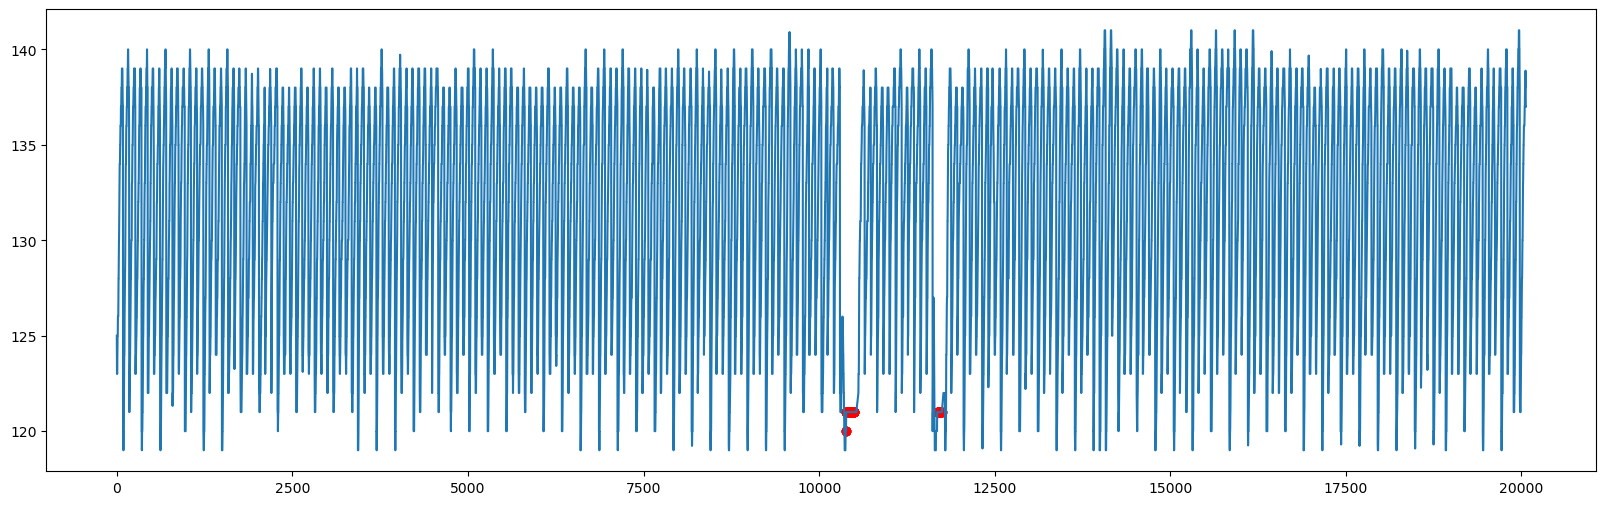

In [238]:
plt.clf()
df_subset = df.iloc[anomalous_data_indices]
fig, ax = plt.subplots(figsize=(20, 6))
df.plot(legend=False, ax=ax)
#df_subset.plot(legend=False, ax=ax, color="r")
ax.scatter(df_subset.index, df_subset['Sensor'], c='red', label='Anomalous Data', marker='o')
plt.show()

<Figure size 640x480 with 0 Axes>

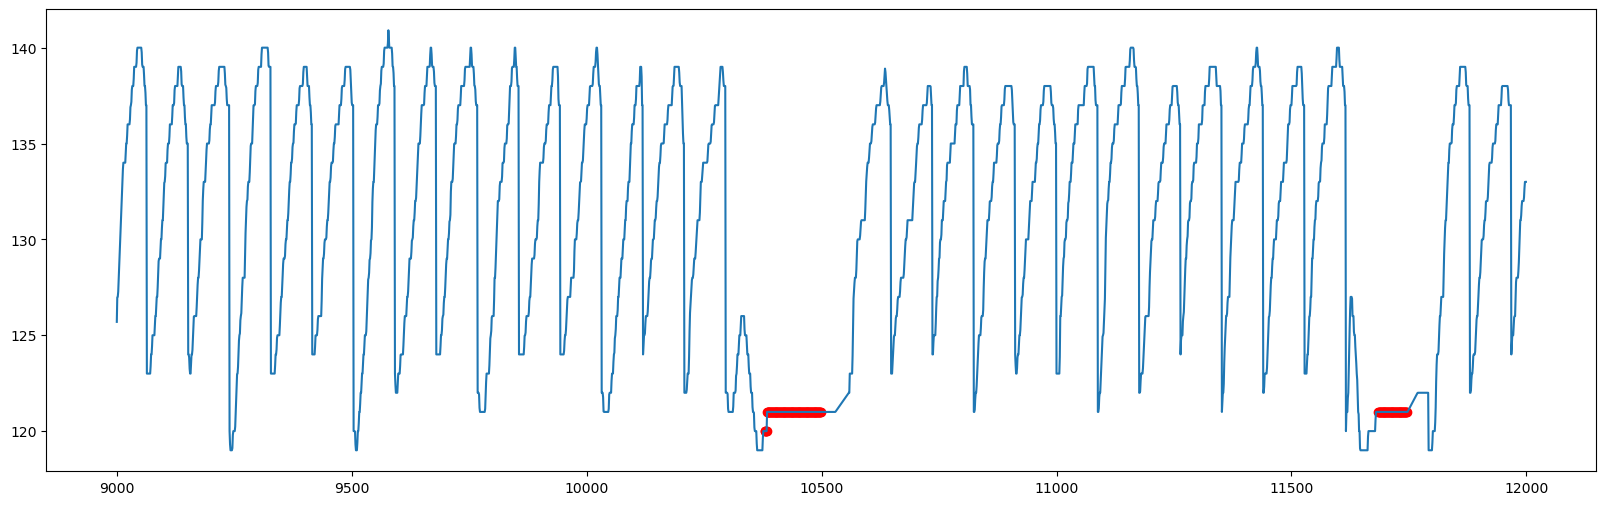

In [239]:
# Zoom into the data
plt.clf()
start_range = 9000
end_range = 12000
zoom_df=df.iloc[start_range:end_range]
zoom_anomalous_data_indices = [idx for idx in anomalous_data_indices if start_range <= idx <= end_range]
zoom_df_subset = df.iloc[zoom_anomalous_data_indices]
fig, ax = plt.subplots(figsize=(20, 6))
zoom_df.plot(legend=False, ax=ax)
ax.scatter(zoom_df_subset.index, zoom_df_subset['Sensor'], c='red', label='Anomalous Data', marker='o')
plt.show()

<h2>Conclusion: The AutoEncoder method seems workable but requires more finetuning and calibration of the "threshold" level to get more accurate results.

-----

<h1>Sub-reference: AutoEncoder with different tebular format (didn't work well)

In [ ]:
# Load your time series sensor data
# Assuming you have your data in a DataFrame with 'timestamp' and 'value' columns
# Adjust this part to match your data loading procedure

# Preprocess the data
#data = pd.read_csv('sensor_data.csv')
#data['timestamp'] = pd.to_datetime(data['timestamp'])
#data.set_index('timestamp', inplace=True)
#data = data['value'].values.reshape(-1, 1)

#data=df
index_variable = df.index
index_variable = index_variable.astype(int)
data = df.copy()
data = data.reset_index(drop=True)
#data['value'].values.reshape(-1, 1)

In [ ]:
data

In [ ]:
# Normalize the data
#print(data)
#scaler = StandardScaler()
#data = scaler.fit_transform(data)
print(data.shape)
print(type(data))
# Try without scaling
data = data.to_numpy()

# Split the data into train and test sets
X_train, X_test = train_test_split(data, test_size=0.2, random_state=42)

# Build the autoencoder model
input_dim = X_train.shape[1]
print(input_dim)
encoding_dim = 32

In [ ]:
input_layer = keras.layers.Input(shape=(input_dim,))
encoder = keras.layers.Dense(encoding_dim, activation='relu')(input_layer)
decoder = keras.layers.Dense(input_dim, activation='sigmoid')(encoder)

autoencoder = keras.models.Model(inputs=input_layer, outputs=decoder)

In [ ]:
# Compile the model
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
#autoencoder.compile(optimizer='rmsprop', loss='mean_squared_error')

# Train the autoencoder
autoencoder.fit(X_train, X_train, epochs=20, batch_size=16, shuffle=True, validation_data=(X_test, X_test))

In [ ]:
# Use the trained autoencoder for anomaly detection
predictions = autoencoder.predict(X_test)
reconstruction_error = np.mean(np.power(X_test - predictions, 2), axis=1)

# Set a threshold for anomaly detection
threshold = np.percentile(reconstruction_error, 98)  # Adjust the percentile as needed

# Identify anomalies
anomalies = X_test[reconstruction_error > threshold]

print(anomalies.shape)
#anomalies

In [ ]:
# Use the trained autoencoder for anomaly detection
predictions = autoencoder.predict(data)
reconstruction_error = np.mean(np.power(data - predictions, 2), axis=1)
predictions_df=pd.DataFrame(predictions)
predictions_df

In [ ]:
# Set a threshold for anomaly detection
threshold = np.percentile(reconstruction_error, 90)  # Adjust the percentile as needed
print(threshold)
#reconstruction_error

In [ ]:
# Identify anomalies
anomalies = data[reconstruction_error > threshold]

print(anomalies.shape)
#anomalies
data
data_df=pd.DataFrame(data)
#data_df

In [ ]:
plt.figure(figsize=(10, 3))
anomalies_df=pd.DataFrame(anomalies)
for index, row in anomalies_df.iterrows():
    plt.plot(row, label=f'Line {index}')  # Plot each row with a label
plt.show()

In [ ]:
list0=data[0]
plt.figure(figsize=(10, 3))
plt.plot(list0)

In [ ]:
list0

In [ ]:
# Sample code
from keras.layers import Input, Dense
from keras.models import Model

   input_dim = X_train.shape[1]
   encoding_dim = 32

   input_layer = Input(shape=(input_dim,))
   encoder = Dense(encoding_dim, activation='relu')(input_layer)
   decoder = Dense(input_dim, activation='sigmoid')(encoder)

   autoencoder = Model(input_layer, decoder)
   autoencoder.compile(optimizer='adam', loss='mean_squared_error')
   autoencoder.fit(X_train, X_train, epochs=10, batch_size=32)

In [ ]:
#Reference:https://keras.io/examples/timeseries/timeseries_anomaly_detection/